In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing

import re #remove char
from sklearn import metrics

#Main train
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout


#Graph build
import matplotlib.pyplot as plt
import matplotlib.lines

Using TensorFlow backend.


In [4]:
dataset = pd.read_csv("./input/FakeNewsDataset.csv")

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   category  44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [6]:
dataset.head(10)

,title,text,category
0,Zimbabwe's Mnangagwa promises zero tolerance i...,HARARE (Reuters) - Zimbabwean President Emmers...,1
1,"Malay woman to be Singapore president, puts mi...",SINGAPORE (Reuters) - There are no Muslim Mala...,1
2,Egyptian president to meet Trump at White Hous...,WASHINGTON (Reuters) - U.S. President Donald T...,1
3,Germany's far-right AfD has more immigrant MPs...,BERLIN (Reuters) - The anti-immigrant Alternat...,1
4,OBAMA’S EPA PUSHES FOR TOUGHER MILEAGE STANDAR...,The EPA continues to push for more and more re...,0
5,Two Turkish soldiers killed in northern Iraq: ...,ISTANBUL (Reuters) - Two Turkish soldiers were...,1
6,Two-thirds of Japan voters oppose PM Abe calli...,TOKYO (Reuters) - Almost two-thirds of Japanes...,1
7,OFF HER ROCKER! MAXINE WATERS: Trump Has ‘Tend...,"Rep. Maxine Waters (D., Calif.) Monday accused...",0
8,"Trump praises 'productive' China talks, but to...",BEIJING (Reuters) - U.S. President Donald Trum...,1
9,TX Professors Told Not To Upset Armed Student...,This is what it has come to.Following the pass...,0


In [7]:
dataset['text'] = dataset['title']+' '+dataset['text']
del dataset['title']

In [8]:
dataset.head(10)

,text,category
0,Zimbabwe's Mnangagwa promises zero tolerance i...,1
1,"Malay woman to be Singapore president, puts mi...",1
2,Egyptian president to meet Trump at White Hous...,1
3,Germany's far-right AfD has more immigrant MPs...,1
4,OBAMA’S EPA PUSHES FOR TOUGHER MILEAGE STANDAR...,0
5,Two Turkish soldiers killed in northern Iraq: ...,1
6,Two-thirds of Japan voters oppose PM Abe calli...,1
7,OFF HER ROCKER! MAXINE WATERS: Trump Has ‘Tend...,0
8,"Trump praises 'productive' China talks, but to...",1
9,TX Professors Told Not To Upset Armed Student...,0


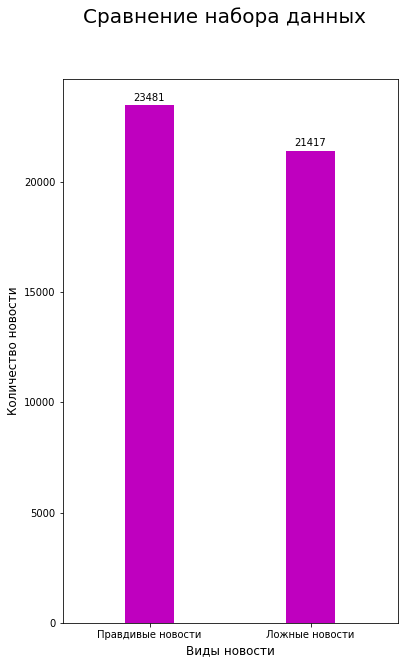

In [9]:
x_axis = ['Правдивые новости', 'Ложные новости']
y_axis = [list(dataset['category']).count(0), list(dataset['category']).count(1)]

plt.figure(figsize = (6, 10))
plt.bar(x_axis, y_axis, width = 0.3, color = 'm')

for i, value in enumerate(y_axis):
    plt.text(i-0.1, value+200, str(value))

plt.suptitle('Сравнение набора данных', fontsize = 20)
plt.margins(x = 0.3)

plt.rc('ytick', labelsize = 15)
plt.rc('xtick', labelsize = 15)

plt.xlabel('Виды новости', fontsize = 12)
plt.ylabel('Количество новости', fontsize = 12)

plt.show()

**DATA CLEANING**

In [10]:
def to_lower_case(text):
    return text.lower()
to_lower_case('Kim Jong-un Dead?')

'kim jong-un dead?'

In [11]:
def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

remove_URLs('Vietnam has reported no coronavirus deaths – how?: https://theconversation.com/vietnam-has-reported-no-coronavirus-deaths-how-136646')

'Vietnam has reported no coronavirus deaths – how?: '

In [12]:
def remove_HTMLs(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
remove_HTMLs('The <strong>UFOs</strong> have been found')

'The UFOs have been found'

In [13]:
def remove_annotations(text):
    annotation = re.compile(r'\[[^]]*\]')
    return annotation.sub(r'', text)
remove_annotations('People in Vietnam try black cat paste to ward off coronavirus [Daily News]')


'People in Vietnam try black cat paste to ward off coronavirus '

In [14]:
def remove_punctuations(text):
    punctuation = re.compile(r'[^a-zA-Z0-9]+')
    return punctuation.sub(r' ', text)
remove_punctuations('FBI Russia probe helped by Australian diplomat tip-off: NYT.')

'FBI Russia probe helped by Australian diplomat tip off NYT '

In [15]:
#Stop words removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_list = set(stopwords.words('english'))

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    return ' '.join(text)

remove_stopwords("People in Vietnam try black cat paste to ward off coronavirus!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/minhthienlongvo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'People Vietnam try black cat paste ward coronavirus!'

In [16]:
#Lemmatization
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def pos_recognition(tag):
    if (tag[0] == 'J'):
        return 'a'
    if (tag[0] == 'N'):
        return 'n'
    if (tag[0] == 'R'):
        return 'r'
    if (tag[0] == 'V'):
        return 'v'
    return ''

def lemmatization(text):
    text = nltk.pos_tag(text.split())
    for i in range(len(text)):
        if (pos_recognition(text[i][1]) != ''):
            text[i] = lemmatizer.lemmatize(text[i][0], pos = pos_recognition(text[i][1]))
        else:
            text[i] = lemmatizer.lemmatize(text[i][0])
    return ' '.join(text)

lemmatization('Coronavirus is continuing its spread across the world with more than three and a half million confirmed cases in 187 countries')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/minhthienlongvo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


'Coronavirus be continue it spread across the world with more than three and a half million confirmed case in 187 country'

In [17]:
def data_preprocessing(dataset):
    corpus = []
    for i, data in enumerate(dataset):
        data = to_lower_case(data)
        data = remove_HTMLs(data)
        data = remove_URLs(data)
        data = remove_annotations(data)
        data = remove_punctuations(data)
        data = remove_stopwords(data)
        data = lemmatization(data)
        corpus.append(data)
    return corpus

processed_dataset = data_preprocessing(dataset.text)

In [18]:
from termcolor import colored
for i in range(5):
        print(colored('Before data cleaning:', 'blue'))
        print(' '.join(dataset['text'][i].split()[:10]), ' ...')
        print(colored('After data cleaning:', 'blue'))
        print(' '.join(processed_dataset[i].split()[:10]), ' ...')

Before data cleaning:
Zimbabwe's Mnangagwa promises zero tolerance in corruption fight HARARE (Reuters)  ...
After data cleaning:
zimbabwe mnangagwa promise zero tolerance corruption fight harare reuters zimbabwean  ...
Before data cleaning:
Malay woman to be Singapore president, puts minority representation on  ...
After data cleaning:
malay woman singapore president put minority representation agenda singapore reuters  ...
Before data cleaning:
Egyptian president to meet Trump at White House on April  ...
After data cleaning:
egyptian president meet trump white house april 3 washington reuters  ...
Before data cleaning:
Germany's far-right AfD has more immigrant MPs than Merkel's conservatives  ...
After data cleaning:
germany far right afd immigrant mp merkel conservative berlin reuters  ...
Before data cleaning:
OBAMA’S EPA PUSHES FOR TOUGHER MILEAGE STANDARDS FOR TRUCKS The  ...
After data cleaning:
obama epa push tough mileage standard truck epa continue push  ...


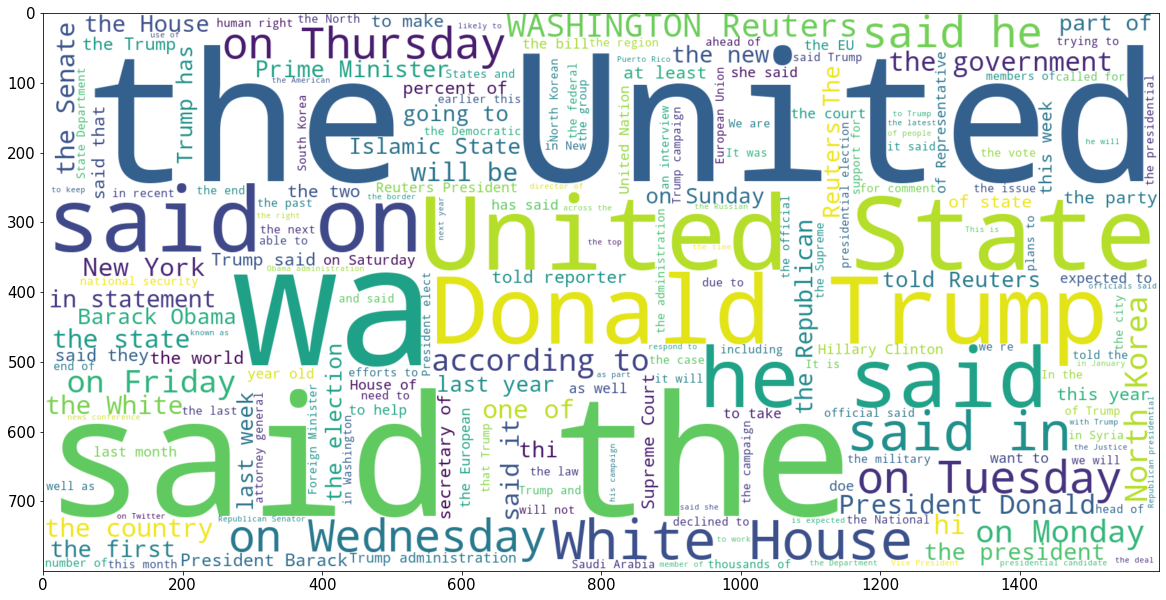

In [20]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 200,
               width = 1600,
               height = 800,
               background_color = 'white',
               stopwords = STOPWORDS).generate(" ".join(dataset[dataset.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

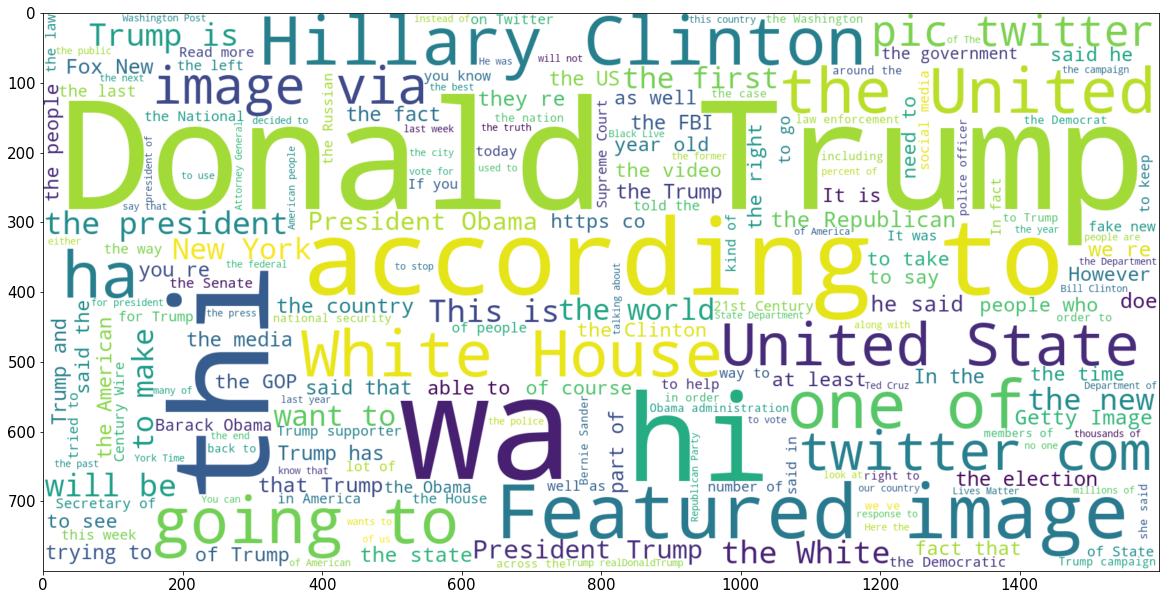

In [21]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 200,
               width = 1600,
               height = 800,
               background_color = 'white',
               stopwords = STOPWORDS).generate(" ".join(dataset[dataset.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Import GloVe**

In [22]:
glove = {}
for line in open('./glove/glove.twitter.27B.200d.txt', 'r', encoding = 'utf-8'):
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector


In [23]:
from scipy import spatial
def find_closest_embeddings(query):
    dist = []
    for word in glove.keys():
        dist.append((spatial.distance.euclidean(glove[word], query), word))
    return sorted(dist)

In [24]:
find_closest_embeddings(glove["vietnam"])[:5]

[(0.0, 'vietnam'),
 (5.046778202056885, 'taiwan'),
 (5.226627349853516, 'thailand'),
 (5.3922929763793945, 'laos'),
 (5.422412872314453, 'china')]

In [25]:
find_closest_embeddings(
    glove["moscow"] - glove["russia"] + glove["vietnam"])[:5]

[(5.033226490020752, 'vietnam'),
 (5.791561603546143, 'hanoi'),
 (6.39085054397583, 'saigon'),
 (6.445601463317871, 'bangkok'),
 (6.4767608642578125, 'taiwan')]

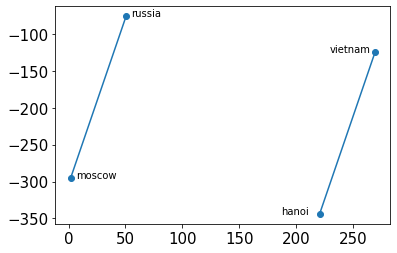

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 0)
words_example =  ['hanoi', 'moscow', 'vietnam', 'russia']
vectors_example = [glove[word] for word in words_example]

X = tsne.fit_transform(vectors_example)[:, 0]
Y = tsne.fit_transform(vectors_example)[:, 1]
plt.scatter(X, Y)

plt.annotate('vietnam', xy = (X[0], Y[0]), xytext = (-45, 0), textcoords = "offset points")
plt.annotate('moscow', xy = (X[1], Y[1]), xytext = (5, 0), textcoords = "offset points")
plt.annotate('hanoi', xy = (X[2], Y[2]), xytext = (-38, 0), textcoords = "offset points")
plt.annotate('russia', xy = (X[3], Y[3]), xytext = (5, 0), textcoords = "offset points")

hanoi_vietnam_lines = matplotlib.lines.Line2D([X[0], X[2]], [Y[0], Y[2]])
moscow_russia_lines = matplotlib.lines.Line2D([X[1], X[3]], [Y[1], Y[3]])
plt.gca().add_line(hanoi_vietnam_lines)
plt.gca().add_line(moscow_russia_lines)

plt.show()

In [27]:
glove['news']

array([ 1.8068e-01,  3.7165e-01, -9.3690e-01, -6.7294e-01, -1.7049e-01,
       -6.0568e-01, -3.5573e-01,  1.5797e-01,  3.2141e-01, -6.0132e-01,
       -1.9792e-02, -1.6511e-01, -1.1925e+00,  4.2199e-01,  4.7333e-01,
       -6.1677e-01, -3.9436e-01, -3.4446e-02,  3.5144e-01, -3.9020e-01,
        4.3312e-01, -1.2628e-01, -7.6018e-02,  2.5449e-01, -5.7366e-02,
        5.0812e-01, -6.4219e-01, -6.0287e-01, -5.7303e-01, -1.5910e-01,
       -2.8255e-01, -5.3155e-01, -2.1370e-01, -1.1614e-01,  9.3703e-01,
        8.1281e-02,  4.8438e-01,  2.2901e-01, -2.0620e-01, -7.5368e-01,
       -4.5938e-01, -5.3754e-01, -2.9300e-01, -1.8464e-01, -8.5235e-02,
        3.5927e-01,  1.3041e-01, -2.0205e-01, -4.0036e-01, -1.6461e-01,
        2.6593e-01,  1.7138e-03, -1.4691e-01,  6.0469e-01,  1.6276e-01,
        3.7655e-01, -1.3538e-01,  9.2645e-03,  1.1953e-01,  1.5389e-01,
       -1.5596e-01,  1.9246e-01, -1.3150e-01,  5.0046e-01, -4.0873e-01,
        2.1456e-01,  2.0126e-01, -2.6077e-01,  4.0373e-01, -2.39

**Splitting the data into 2 parts - training and testing data**

In [28]:
from sklearn.model_selection import train_test_split
train_input, validation_input, train_output, validation_output = train_test_split(processed_dataset, dataset.category)

In [29]:
print('Length of training input: ', len(train_input))
print('Length of training output: ', len(train_output))
print('Length of validation input: ', len(validation_input))
print('Length of validation output: ', len(validation_output))

Length of training input:  33673
Length of training output:  33673
Length of validation input:  11225
Length of validation output:  11225


In [30]:
train_input[0]

'kenya chief justice say police enhance security shoot nairobi reuters kenya chief justice say national police chief enhance security supreme court judge one bodyguard shot deny reuters report request extra security turn judge safety thrust focus last week shoot occur tuesday even next day five seven judge fail come court issue judgment election petition seek delay next day presidential poll spark widespread speculation intimidation senior judicial source tell reuters earlier week shoot judge normally allocate one bodyguard request another vehicle know chaser car follow go ahead move around country source available speak thursday say request turn source also say judge upset government characterisation shoot crime rather attempt intimidate judge recently annul august election victory president uhuru kenyatta statement issue chief justice david maraga office late wednesday say story wrong contrary inspector general police fact enhance security supreme court judge say give detail interior

In [31]:
max_features = 10000
max_length = 300

In [32]:
import keras
tokenizer = keras.preprocessing.text.Tokenizer(num_words = max_features)

def tokenizer_to_sequences(input):
    tokenized_input = tokenizer.texts_to_sequences(input)
    return keras.preprocessing.sequence.pad_sequences(tokenized_input, maxlen = max_length)

In [33]:
tokenizer.fit_on_texts(train_input)
tokenizer.fit_on_texts(validation_input)

train_input = tokenizer_to_sequences(train_input)
validation_input = tokenizer_to_sequences(validation_input)

In [34]:
glove_vectors = list(glove.values())
embedding_matrix = np.zeros((max_features,
                            len(glove_vectors[0])))
for word, i in tokenizer.word_index.items():
    if (i >= max_features):
        break
    embedding_vector = glove.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[i-1] = embedding_vector

In [35]:
embedding_matrix.shape

(10000, 200)

**Some Model Parameters **

In [36]:
batch_size = 256
epochs = 10
dimension = 200

# TRAINING THE MODEL

In [37]:
model = Sequential()
model.add(Embedding(max_features,
                    dimension,
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length = max_length))
#LSTM
model.add(LSTM(units = 128 , return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 200)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          168448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [39]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True)

In [40]:
history = model.fit(train_input, train_output, batch_size = batch_size,
                    validation_data = (validation_input, validation_output),
                    epochs = epochs)

Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 185s 5ms/step - loss: 0.3243 - accuracy: 0.8568 - val_loss: 0.2197 - val_accuracy: 0.9239

# ANALYSIS AFTER TRAINING OF MODEL

In [41]:
print("Accuracy of the model on Training Data is - " , model.evaluate(train_input, train_output)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(validation_input, validation_output)[1]*100)

33673/33673 [==============================] - 92s 3ms/step

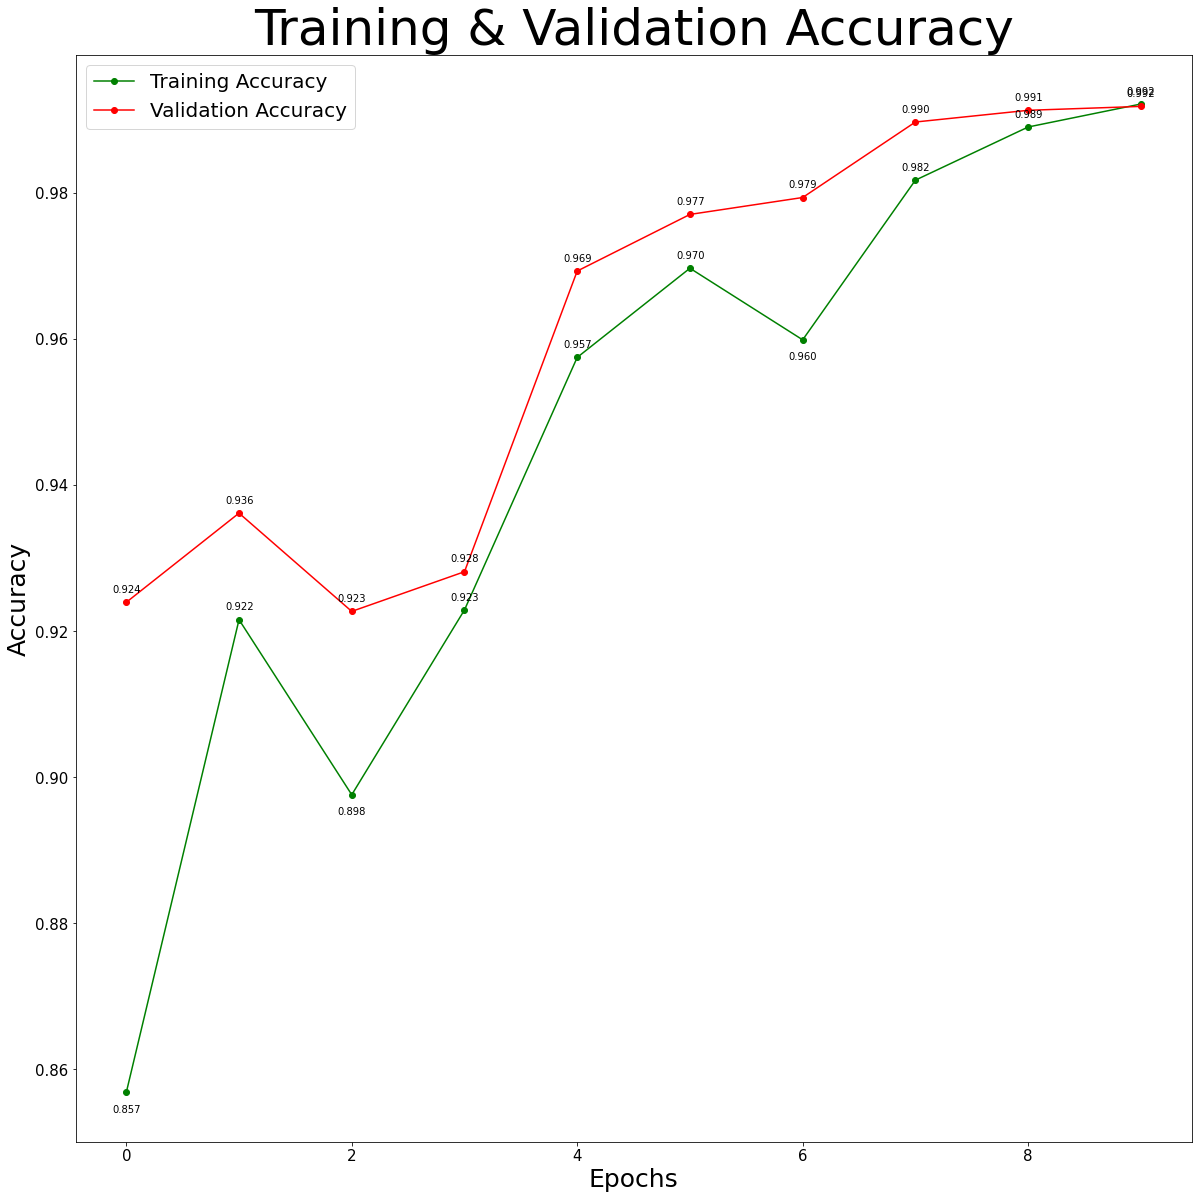

In [42]:
epochs = [i for i in range(10)]
plt.figure(figsize = (20, 20))

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

for i in range(10):
    if (i and train_accuracy[i] > train_accuracy[i-1]):
        plt.annotate(str('{0:.3f}'.format(train_accuracy[i])),
                     xy = (epochs[i], train_accuracy[i]),
                     xytext = (-14, 10),
                     textcoords = "offset points")
    else:
        plt.annotate(str('{0:.3f}'.format(train_accuracy[i])),
                     xy = (epochs[i], train_accuracy[i]),
                     xytext = (-14, -20),
                     textcoords = "offset points")

for i in range(10):
    if (i != 10):
        plt.annotate(str('{0:.3f}'.format(validation_accuracy[i])),
                     xy = (epochs[i], validation_accuracy[i]),
                     xytext = (-14, 10),
                     textcoords = "offset points")
    else:
        plt.annotate(str('{0:.3f}'.format(validation_accuracy[i])),
                     xy = (epochs[i], validation_accuracy[i]),
                     xytext = (-14, -20),
                     textcoords = "offset points")

plt.plot(epochs, train_accuracy,
         'go-', label = 'Training Accuracy')
plt.plot(epochs, validation_accuracy,
         'ro-', label = 'Validation Accuracy')

plt.title('Training & Validation Accuracy', fontsize = 50)
plt.legend(fontsize = 20)

plt.xlabel("Epochs", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)

plt.savefig('acc_1.png')
plt.show()

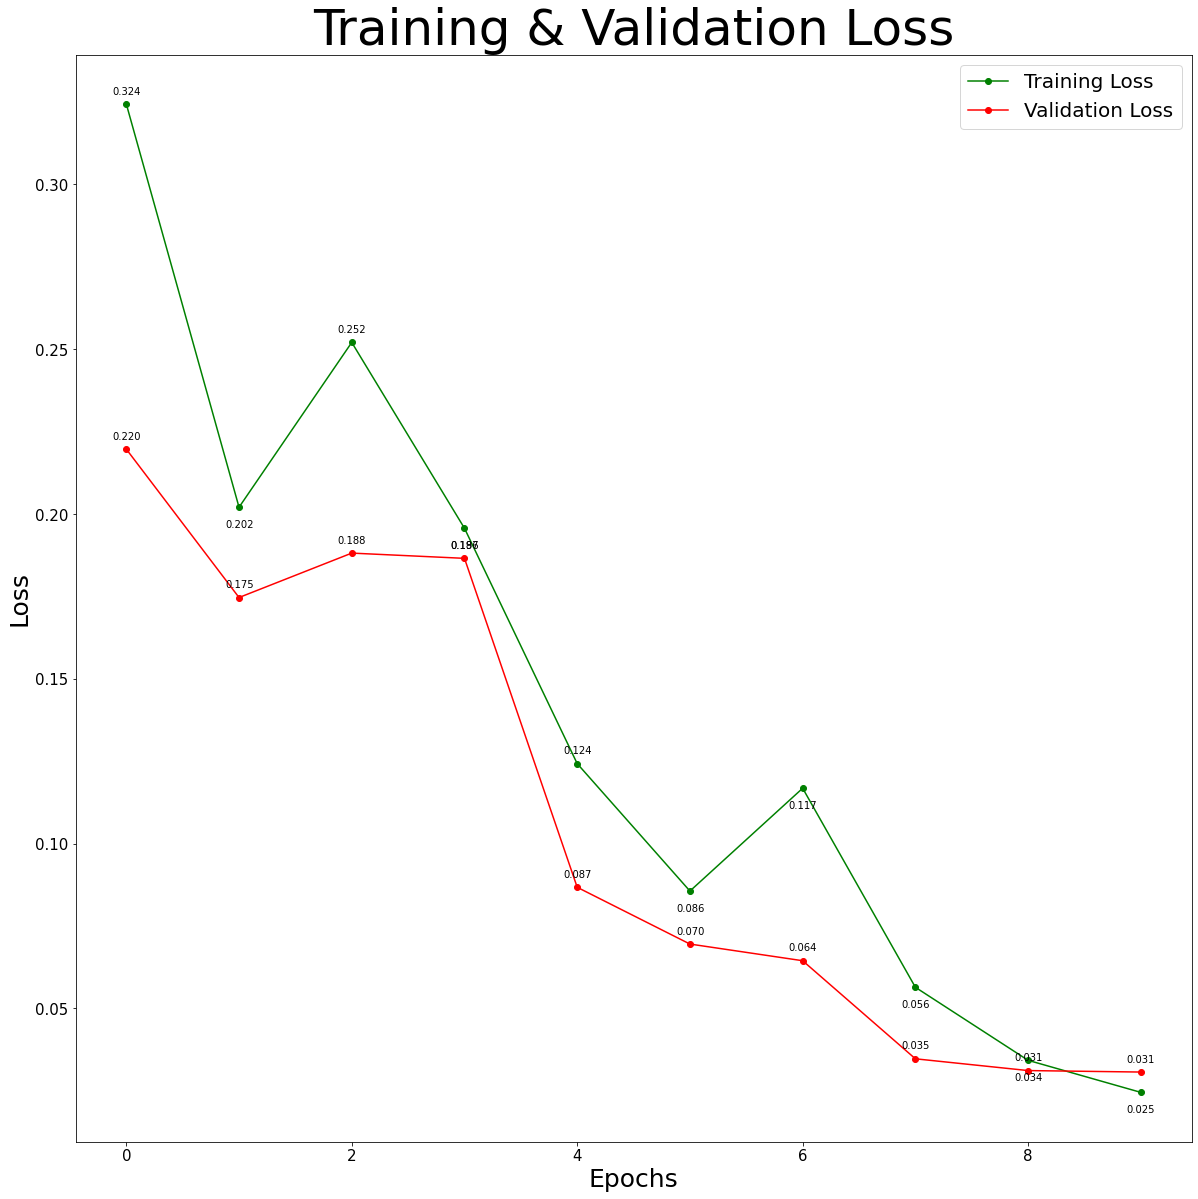

In [43]:
plt.figure(figsize = (20, 20))

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs , train_loss,
         'go-' , label = 'Training Loss')
plt.plot(epochs , validation_loss,
         'ro-' , label = 'Validation Loss')

for i in range(10):
    if (i == 0 or i == 2 or i == 4):
        plt.annotate(str('{0:.3f}'.format(train_loss[i])),
                     xy = (epochs[i], train_loss[i]),
                     xytext = (-14, 10),
                     textcoords = "offset points")
    else:
        plt.annotate(str('{0:.3f}'.format(train_loss[i])),
                     xy = (epochs[i], train_loss[i]),
                     xytext = (-14, -20),
                     textcoords = "offset points")

for i in range(10):
    if (i != 10):
        plt.annotate(str('{0:.3f}'.format(validation_loss[i])),
                     xy = (epochs[i], validation_loss[i]),
                     xytext = (-14, 10),
                     textcoords = "offset points")
    else:
        plt.annotate(str('{0:.3f}'.format(validation_loss[i])),
                     xy = (epochs[i], validation_loss[i]),
                     xytext = (-14, -20),
                     textcoords = "offset points")

plt.title('Training & Validation Loss', fontsize = 50)
plt.legend(fontsize = 20)

plt.xlabel("Epochs", fontsize = 25)
plt.ylabel("Loss", fontsize = 25)

plt.savefig('loss_1.png')
plt.show()

In [44]:
prediction = model.predict_classes(validation_input)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(validation_output, prediction, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      5857
        True       0.99      1.00      0.99      5368

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_output, prediction)
cm = pd.DataFrame(cm , index = ['Fake','True'] , columns = ['Fake','True'])

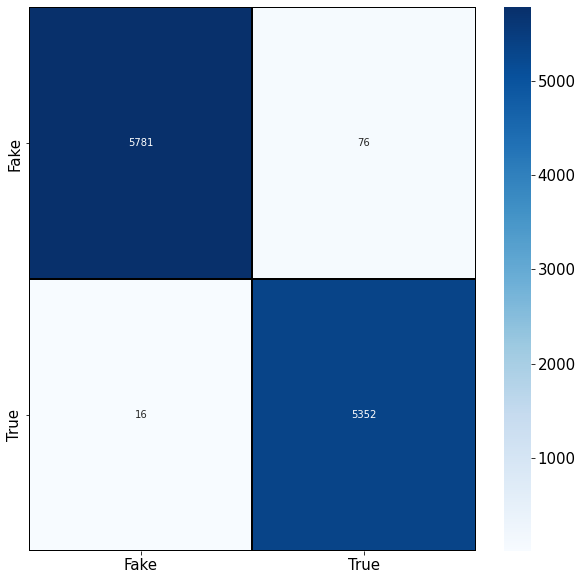

In [49]:
import seaborn as sns
plt.figure(figsize = (10, 10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'])
plt.savefig("heatmap.png")

In [48]:
test_title = ['Zimbabwe s Mnangagwa promises zero tolerance in corruption fight',
              'Malay woman to be Singapore president, puts minority representation on agenda',
              'Egyptian president to meet Trump at White House on April 3',
              'Germany s far-right AfD has more immigrant MPs than Merkel s conservatives',
              'OBAMA’S EPA PUSHES FOR TOUGHER MILEAGE STANDARDS FOR TRUCKS',
              'Two Turkish soldiers killed in northern Iraq: Turkish military',
              'Two-thirds of Japan voters oppose PM Abe calling snap election: Kyodo survey',
              'OFF HER ROCKER! MAXINE WATERS: Trump Has ‘Tendency to Talk Down to People of Color’ [Video]',
              'Trump praises productive China talks, but tough action seen ahead',
              ' TX Professors Told Not To Upset Armed Students To Avoid Shootings Following ‘Campus Carry’ Law'
              ]

test_text = ['HARARE (Reuters) - Zimbabwean President Emmerson Mnangagwa on Wednesday promised zero tolerance in his government s push to punish corruption that stifled political freedom and economic growth under Robert Mugabe s 37-year rule. Mnangagwa, giving his first state of the nation address since he assumed power last month following a de facto coup that ousted his 93-year-old predecessor, has sought to draw a line under years of endemic corruption and impunity.  Under pressure to deliver results, especially on an economy crippled by severe currency shortages, Mnangagwa said reforms of a bloated state sector would be launched in early 2018.  With opposition parties calling for widespread political reforms before an election next year, he repeated a promise that his government would do everything in its power to ensure a credible, free and fair ballot.  Corruption remains the major source of some of the problems we face as a country and its retarding impact on national development cannot be overemphasized,  Mnangagwa told a joint sitting of the country s two houses of parliament.  On individual cases of corruption, every case must be investigated and punished in accordance with the dictates of our laws. There should be no sacred cows. My government will have zero tolerance towards corruption and this has already begun.  The latter was an apparent reference to comments last week he would name and shame those who failed to return stolen public funds after a three-month amnesty ends in February.  His government is also pursuing corruption charges dating back over two decades against former finance minister Ignatius Chombo, a close ally of Mugabe and his wife, Grace. Chombo, whose lawyer has said he will deny the charges, faces trial early next year. In the latter half of Mugabe s rule the economy fell apart amid the violent and chaotic seizure of thousands of white-owned commercial farms. Billions of dollars of domestic debt issued to pay for a bloated civil service triggered a collapse in the value of Zimbabwe s de facto currency and hyperinflation.     Mnangagwa said the government would in the first quarter of next year announce a program to reform, commercialize or shut down some state-owned firms he said had been  for a long time an albatross around the government s neck . Zimbabwe s efforts to re-engage international lenders and lure investors will rest on the credibility of next year s election, and the president again pledged a commitment to a free and fair vote. To level a playing field they say is skewed in favor of Mnangagwa s ZANU-PF party, opposition parties have however challenged his army-backed government to first enact a long list of electoral reforms. They include a new voters  roll, opposition access to public media, allowing an estimated three million Zimbabweans living abroad to vote and international observers including the United Nations.  We would like to see genuine, credible electoral reforms that will lead to free and fair elections and they must be underwritten and guaranteed by the international community,  Tendai Biti, leader of the opposition MDC Alliance, told reporters ahead of Mnangagwa s address. Biti and other members of the alliance also criticized what they called the  militarization  of the government following the appointment of two former senior military officials to the new cabinet.  Mnangagwa gave his clearest signal yet on Tuesday that he would appoint as vice president Constantino Chiwenga, the military leader who led the coup that ousted Mugabe. Chris Mutsvangwa, adviser to the president and the influential leader of the war veterans  association, has rejected the criticism of the appointments, saying they were not unique to Zimbabwe.',
             'SINGAPORE (Reuters) - There are no Muslim Malays in the top echelons of Singapore s army, and few among the senior ranks of its judiciary, but a member of its poorest ethnic minority is set to become the first woman president of the Southeast Asian city state this week. Halimah Yacob, a former speaker of parliament, will be formally named to the mostly ceremonial post on Wednesday,  media reported, after other candidates fell short of the criteria set for contesting the election. Aiming to strengthen a sense of inclusivity in the multicultural country, Singapore had decreed the presidency would be reserved for candidates from the Malay community this time. Halimah s experience as house speaker automatically qualified her under the nomination rules.  Of the four other applicants, two were not Malays and two were not given certificates of eligibility, the elections department said. The last Malay to hold the presidency was Yusof Ishak, whose image adorns the country s banknotes. Yusof was president between 1965 and 1970, the first years of Singapore s independence following a short-lived union with neighboring Malaysia, but executive power lay with Lee Kuan Yew, the country s first prime minister. The separation of Singapore from Malaysia gave ethnic Malays a clear majority in Malaysia, while ethnic Chinese formed the majority in independent Singapore. Leaders of both countries, however, recognized that peace and prosperity depended on preserving harmony between the two groups. But living in a Muslim-dominated neighborhood, with Malaysia and Indonesia next door, Singapore s leaders have long worried about the risk of conflicted loyalties among Malays.  You put in a Malay officer who s very religious and who has family ties in Malaysia in charge of a machine-gun unit, that s a very tricky business,  the late Lee Kuan Yew was widely quoted as saying in 1999. For Lee, whose son, Lee Hsien Loong, is now prime minister, the answer to social cohesion lay in creating a culture of meritocracy, rather than adopting policies of positive discrimination to boost the chances of advancement for Singapore s Malay and Indian minorities. Still, a government report published in 2013 found Malays  felt they were sometimes discriminated against and had limited prospects in some institutions, such as the armed forces.  Singapore s economic success and education policies have helped swell the ranks of middle-class Malays, but the last census in 2010 showed they lagged other ethnic groups on socio-economic measures such as household incomes and home ownership. Malays, who form just over 13 percent of Singapore s 3.9 million citizens and permanent residents, also underperform on measures such as university and secondary school education. Despite being the establishment candidate, Halimah wears a hijab, which is banned in state schools and public sector jobs that require uniforms. But she has seldom spoken publicly on the issue and there is little sign of change in official attitudes.  Farid Khan, one of the unsuccessful candidates and the chairman of marine services firm Bourbon Offshore Asia, told Reuters more Malays now hold political office, and some are making their way in the corporate world, but  there is still room for improvement.  The prospect of a Malay president is by itself unlikely to resolve concerns over under-representation, but analysts and advocates say it could help foster trust among communities.  Yet the reserved election has also injured some pride.  It cheapens the credibility of a Malay person that it requires a token election for us to be president,  said Malay comedian and television personality Hirzi Zulkiflie.  Some people intending to run are very capable.',
             'WASHINGTON (Reuters) - U.S. President Donald Trump will meet with Egyptian President Abdel Fattah al-Sisi at the White House on April 3, the White House said on Tuesday. They will discuss how to defeat Islamic State militants and efforts to pursue peace and stability in the region, the White House said in a statement.',
             'BERLIN (Reuters) - The anti-immigrant Alternative for Germany (AfD) will have proportionally more lawmakers with an immigrant background in the new parliament than Chancellor Angela s conservatives, according to a survey. The AfD, which enters parliament for the first time after winning 12.6 percent of the vote in Sunday s election, has been sharply critical of Merkel s decision to take in 1.3 million mainly Muslim migrants and says Islam has no place in Germany. Yet 7.5 percent of the AfD s 93 lawmakers have an immigrant background compared with only 2.5 percent of the conservatives, according to the survey by Mediendienst Integration, an online portal that collects data on immigration and asylum. That leaves the AfD and the conservative bloc each with seven lawmakers with a recent immigrant background.  Ironically, by entering parliament, the anti-immigrant AfD has contributed to a rise in the number of deputies with an immigration background,  said Jannis Panagiotidis of Osnabrueck University. Some 22.5 percent of Germany s 82 million population have an immigrant background, which means they did not have German citizenship at birth or were born to at least one parent who was not born German. Merkel s Christian Democrats (CDU) and their Christian Social Union (CSU) Bavarian allies won most seats in the election on Sept. 24, which secured Merkel a fourth term but saw her conservatives  support plunge to its lowest level in the post-war period. The CDU/CSU, which together have 246 seats in the Bundestag lower house, are expected to try to build a coalition with the pro-business Free Democrats (FDP) and the Greens. The AfD is the third largest party in the new lower house Bundestag, behind the center-left Social Democrats. The new 709-seat assembly will have a total 57 members with an immigration background, 20 more than in the outgoing Bundestag, which had 630 seats. The far-left Die Linke has the highest percentage of immigrant deputies - nearly 19 percent.',
             'The EPA continues to push for more and more restrictions on emissions. The Obama agenda continues and is bolstered by the Pope s call for action on the global warming scam. Anyone with half a brain can see through this political agenda and knows it has nothing to do with any truth about climate. Crazy times!The Obama administration on Friday proposed tougher mileage standards for medium and heavy-duty trucks, the latest move by President Barack Obama in his second-term drive to reduce pollution blamed for global warming.The Environmental Protection Agency issued new rules that would lower carbon dioxide emissions from trucks and vans by 24 percent by 2027. It would cut fuel costs by about $170 billion and reduce oil consumption by up to 1.8 billion barrels over the lifetime of vehicles sold under the rule.The long-expected rules come one day after Pope Francis issued a teaching document calling for the world to take action to slow climate change.Transportation Secretary Anthony Foxx said in a statement that the new rules would help the environment and the economy, as trucks use less fuel and shipping costs go down. He called the rules  good news all around. Gina McCarthy, chief of the Environmental Protection Agency, said the rules would deliver  big time  on Obama s call to cut carbon pollution. With emission reductions weighing in at 1 billion tons, this proposal will save consumers, businesses and truck owners money,  McCarthy said. At the same time, the rules will  spur technology innovation and job-growth, while protecting Americans  health and our environment over the long haul,  she said.Read more: Sioux City Journal',
             'ISTANBUL (Reuters) - Two Turkish soldiers were killed and one was wounded on Thursday in northern Iraq s Avasin Basyan region by Kurdistan Workers Party (PKK) militants, Turkey s military said. Separately, four militants were killed in the southeastern Turkish province of Tunceli, Dogan news agency said. A ceasefire between the Turkish state and PKK militants broke down in July 2015 and southeast Turkey subsequently saw some of the worst violence since the group launched its insurgency in 1984. More than 40,000 people, mostly Kurds, have been killed in the conflict. The PKK is designated a terrorist group by Turkey, the United States and the European Union.',
             'TOKYO (Reuters) - Almost two-thirds of Japanese voters are opposed to Prime Minister Shinzo Abe calling a snap election, a Kyodo news agency survey showed on Sunday, a day before the Japanese leader is expected to announce an October vote. According to the survey, 27 percent of the respondents plan to vote for the ruling Liberal Democratic Party in proportional representation districts in the expected lower house election, versus 8 percent who favor the struggling main opposition Democratic Party. The poll also showed that 6.2 percent will vote for a new party aligned with popular Tokyo Governor Yuriko Koike, which is expected to be launched this week. Another 42.2 percent remain undecided. Abe is expected on Monday to announce plans to call a general election for Oct. 22 to take advantage of a rebound in his damaged approval ratings and an opposition in political disarray, ruling party and government sources said.',
             'Rep. Maxine Waters (D., Calif.) Monday accused President Donald Trump of having a tendency to target women and people of color for his ire.Waters spoke uninterrupted for almost four minutes on MSNBC s  The Beat  about the Trump Administration s handling of the aftermath of Army Sgt. La David Johnson s death in Niger. She called on Trump and his Chief of Staff John Kelly to apologize to widow Myeshia Johnson and Rep. Frederica Wilson (D., Fla.), going on to criticize Trump s disrespect for women and minorities in general. He seems to have this tendency to talk down to people of color, to treat them with disrespect, and I think this adds to it,  Waters said.  First of all, he called [Wilson] wacky. Secondly, that he didn t back down, that he simply talked about her in a way that was not respectful I think that yes, I think this adds to the suspicion of him and the way that he thinks about minorities and black people in particular. She said Kelly was also wrong in her criticism of Wilson s 2015 speech, and she said she had the backing of the Congressional Black Caucus in saying the Trump Administration needs to do more to respect black women. All of the women of the Congressional Black Caucus have come together and we re demanding an apology,  she said.  We re sick and tired of women being undermined, dismissed, and black women, in particular, being called names. Waters also criticized Trump s overall leadership. He has the most distorted leadership of any president I ve ever known or heard about,  Waters said.  Here he had the opportunity to make the condolence call, to do it properly, to recognize this family and their grieving, and also to know the name of the soldier who had been killed. It is so unconscionable in the way that he manages his leadership,  she added.Waters also said Kelly s credibility has been damaged. General Kelly has had a good career, and to have his career basically undermined by the president of the United States because he s trying to protect the president and stand up for the president when the president did not deserve to be stood up for, now he s damaged himself,  Waters said.  He needs to call the congresswoman and apologize.',
             'BEIJING (Reuters) - U.S. President Donald Trump lauded his Beijing meetings on trade and North Korea as  very productive , ending a visit which Chinese media declared set a  new blueprint  for handling ties, even as the White House looks set for tougher action on China. Trump pressed China to do more to rein in North Korea s nuclear ambitions and said bilateral trade had been unfair to the United States, but also praised Xi s pledge that China would be more open to foreign firms.  Hours after Trump left Beijing on Friday, China said it would drop foreign ownership limits on local banks and asset management companies while loosening stake restrictions in securities firms and insurers - moves that have been long awaited by foreign financial firms. Beijing faces intensifying pressure from Western governments and business lobbies to remove investment barriers and other rules that hobble overseas firms from operating in the country, as well as intellectual property theft. Washington has refrained from pushing harder on trade because it needs China s cooperation on North Korea, although Xi, at least in public, went no further than reiterating China s determination to achieve denuclearization through talks. Trump and Xi, who call themselves friends, also oversaw the signing of about $250 billion in commercial deals, a show that some in the U.S. business community and others say detracts from addressing structural impediments that puts them at a disadvantage to Chinese rivals. China may be mistaken in thinking it had done enough to address U.S. concerns, and Trump could find people disappointed at home he didn t make more progress on items like market access and North Korea, Paul Haenle, Director of the Carnegie Tsinghua Center for Global Policy in Beijing, said.  My concern is you may see a shift towards a much harder line coming from the U.S. administration. That will be a huge surprise to China and President Xi, especially given that Xi likely feels he has done a lot for Trump on this visit.  Trump reiterated in a tweet just before leaving Beijing for the APEC summit of Asia Pacific leaders in Vietnam that he didn t blame China for the trade gap between the two countries, adding that he had  very productive  meetings on trade and North Korea with Xi.  I don t blame China, I blame the incompetence of past Admins for allowing China to take advantage of the U.S. on trade leading up to a point where the U.S. is losing $100 s of billions. How can you blame China for taking advantage of people that had no clue? I would ve done same!  A U.S. industry source said the implication of Trump blaming his predecessors for the trade deficit is that Trump won t make the same mistake - a warning to Xi, not a capitulation.  The Trump administration did not bring hard trade policy items to the discussion with Xi because U.S. officials don t want to  argue over crumbs , the source added.  Barring some dramatic action on North Korea by Xi, there is going to be a hard turn in U.S. trade policy,  the source said. A second source, who is close to the business delegation that traveled to Beijing this week, added that the Trump administration appeared poised to take a much harder line in the weeks ahead. There were no obvious gaffes during the two-night stopover, and Trump and Xi seemed to enjoy being in each other s company. At a banquet on Thursday night in the Great Hall of the People, Trump and Xi dined on coconut chicken soup, spicy chicken, stewed beef with tomatoes and grouper fillets. Chinese state media said the tone and outcome of Trump s visit had been largely positive, saying Trump and Xi were setting a new blueprint for handling relations and managing their differences.    China has tried its utmost, even at the sacrifice of Sino-North Korean relations,  influential tabloid the Global Times wrote in its editorial.   Trump has gradually learned that Beijing is indeed making selfless contributions to promoting the denuclearization of the peninsula. He can t demand more.',
             'This is what it has come to.Following the passage of a Republican-drafted bill to force guns onto college campuses   whether the schools want them there or not   the University of Houston has begun instructing professors to avoid literally triggering students who may be armed in order to avoid sparking a mass shooting. If that sounds ridiculously unhealthy, glad you could join us.In 2015, Republicans in the Texas legislature and Governor Greg Abbott forced through an NRA-drafted bill that would make it mandatory for schools in the state to allow guns on campus. As much as it was adored by right-wing gun lovers, educators and students were appalled. The implications are scary. Students will be packed into classrooms with any number of weapons just waiting to go off by accident or by design.Schools are preparing for the new  guns everywhere  law that will take effect in August, and much of the preparation centers around getting teachers ready to deal with classrooms full of 18-year-olds who brought a semi-automatic handgun to campus along with their textbooks. In a recent discussion of the new state law, the University of Houston displayed a slide that told faculty to  not  go there  on certain topics if they felt it might make some of their gun-happy students upset.Slide from recent campus carry dialogue at UH, in response to faculty concerns about dangers from armed students: pic.twitter.com/610RyhDZlf  Jeff (@JeffintheBowtie) February 22, 2016USA TODAY spoke with the university s faculty senate president: My slides are not university policy but faculty to faculty discussion points in a faculty senate led discussion group. They express the downside of having more weapons on campus and the chilling effect that has on academic freedom,  University Faculty Senate President Jon Snow tells USA TODAY College regarding his presentation.Ironically, many right-wingers have accused schools of  censoring  free speech by being overly  politically correct  in the classroom. It s hard to imagine any school has gone as far as Texas s Republican-led legislature. Professors may be worried students could get offended by a lecture, but few schools have to tell their professors to avoid  triggering  their students or else risk being shot in their classroom.Needless to say, many professors are not okay with this new way of doing things.Despite Republicans assuring the public that they are doing this to keep people safe, the students and professors themselves want nothing to do with this terrifying plan. It s led to demonstrations by students at schools like the University of Texas at Austin, and now, an unprecedented 168 professors from over 30 departments have signed a pledge that they will not take part in this bone-headed scheme.Republicans have ignored their concerns entirely. Instead, they are high-fiving the NRA lobbyists who put them up to it. So a few more kids might die in Texas schools? It s a small price to pay for  freedom. Featured image via Twitter'
             ]

for i in range(len(test_title)):
    test_text[i] = test_title[i]+' '+test_text[i]
test_input = data_preprocessing(test_text)

tokenized_test = tokenizer.texts_to_sequences(test_input)
test_input = keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen = max_length)

test_prediction = model.predict_classes(test_input)
print(test_prediction)

[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]]


In [ ]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_num.h5")

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png', show_shapes=True)